### Visualizing Responses

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
X = np.load('drive/MyDrive/X_data.npy', mmap_mode='r')
y = np.load('drive/MyDrive/Y_data.npy', mmap_mode='r')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


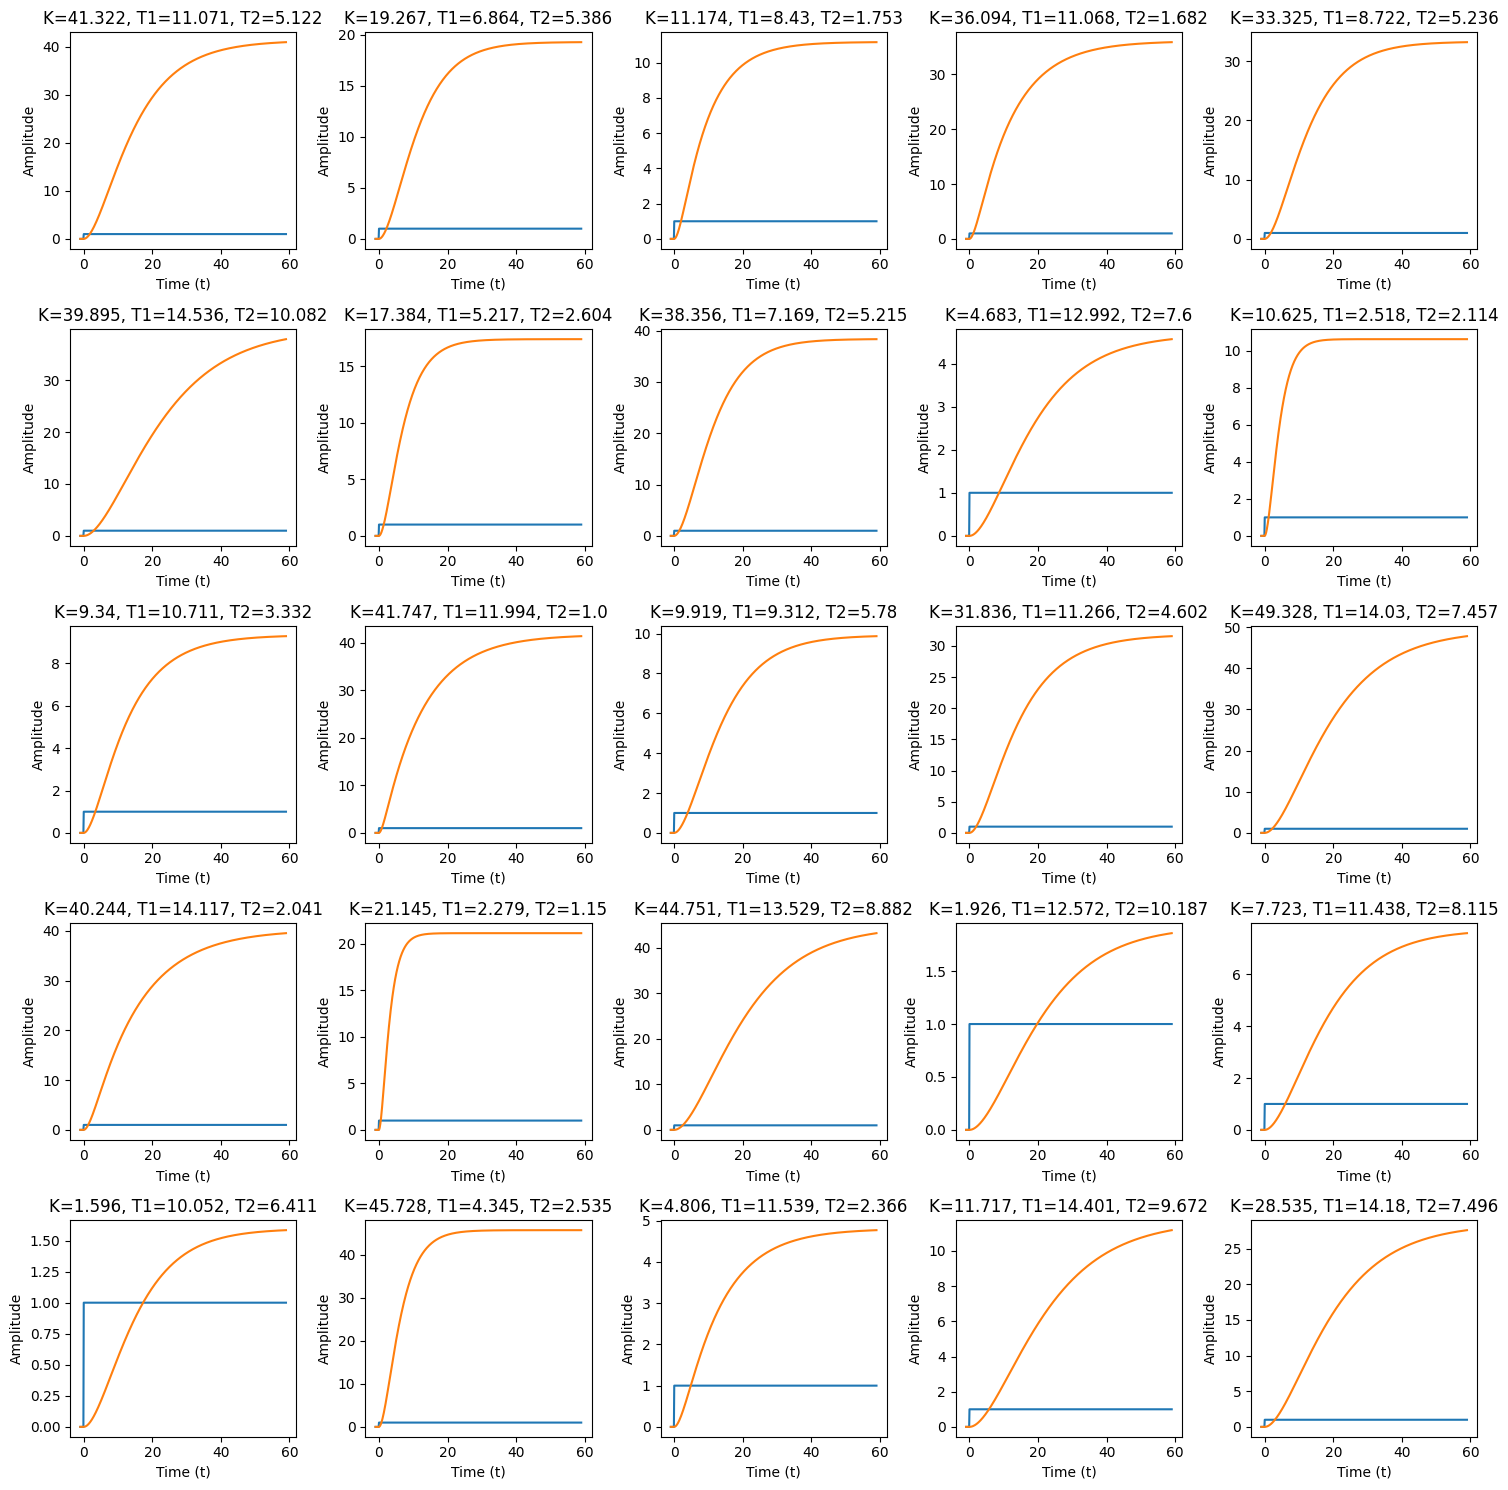

In [5]:
# ...existing code...
responses = X[0:25]
fig, axes = plt.subplots(nrows= 5, ncols=5, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
    t = responses[i][:, 2]
    x_e = responses[i][:, 0]
    x_a = responses[i][:, 1]
    K = y[i][0]
    T1 = y[i][1]
    T2 = y[i][2]
    ax.plot(t, x_e, label='x_e')
    ax.plot(t, x_a, label='x_a')
    ax.set_title(f'K={K}, T1={T1}, T2={T2}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Amplitude')

plt.tight_layout() # Adjust subplot params for a tight layout
plt.show() # Display the figure

### Parameters

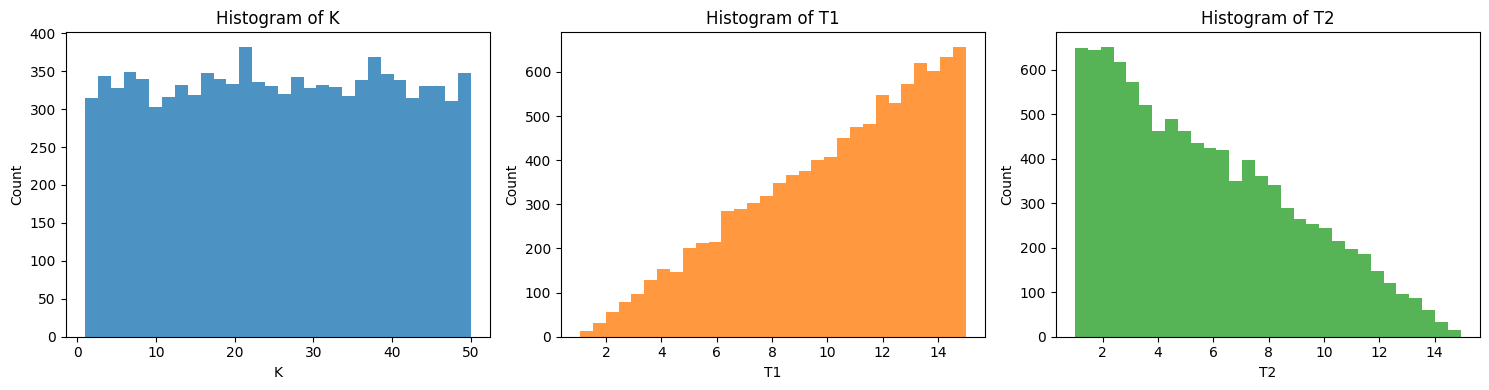

In [6]:
import numpy as np
import matplotlib.pyplot as plt

y = np.asarray(y, dtype=float)  # ensure numeric array, shape (N,3)

labels = ['K', 'T1', 'T2']
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for i, ax in enumerate(axes):
    ax.hist(y[:, i], bins=30, color=f'C{i}', alpha=0.8)
    ax.set_title(f'Histogram of {labels[i]}')
    ax.set_xlabel(labels[i])
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()

### Distributions

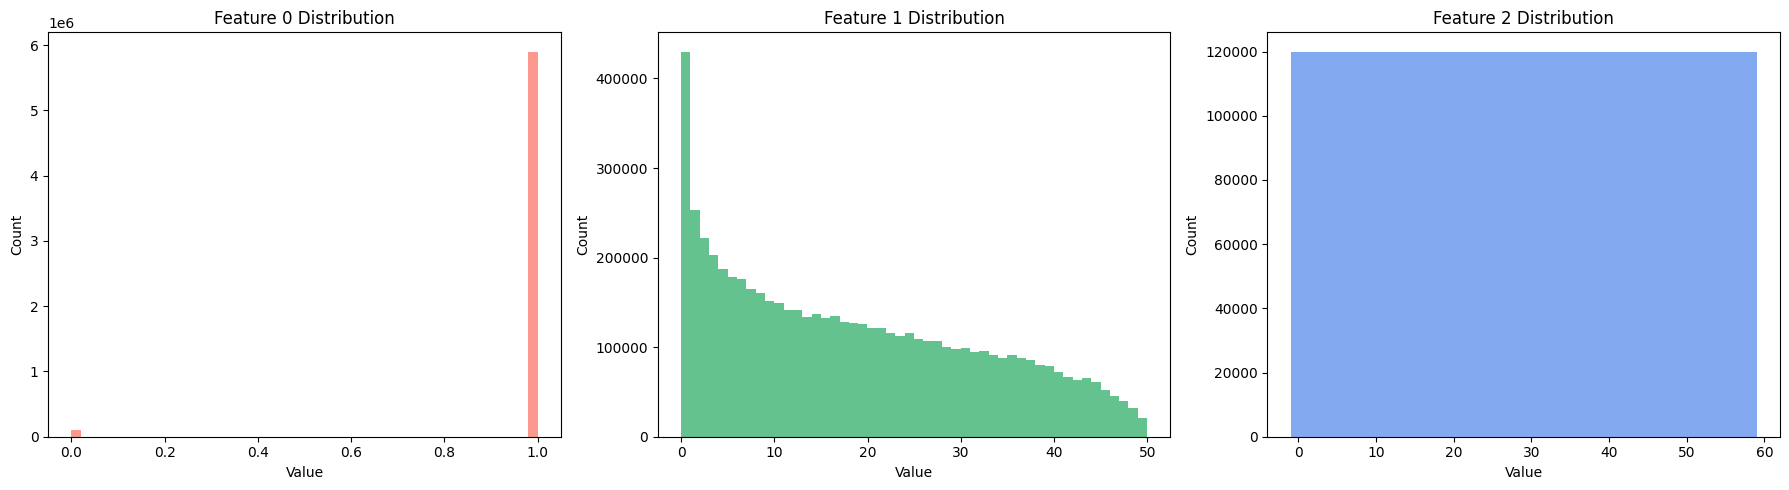

In [7]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['salmon', 'mediumseagreen', 'cornflowerblue']
labels = ['Feature 0', 'Feature 1', 'Feature 2']

for i in range(0,3):
  feat = X[:,:,i].flatten()
  # print(feat) # Commenting out print to avoid large output
  axes[i].hist(feat, bins=50, color=colors[i], alpha=0.8)
  axes[i].set_title(f'{labels[i]} Distribution')
  axes[i].set_xlabel('Value')
  axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

### TRAINING MODEL

In [77]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense


random_state = 42
tf.keras.utils.set_random_seed(random_state)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if len(physical_devices) > 0:
    print(f"Device Name: {physical_devices[0].name}")
else:
    print("⚠️ No GPU found. Training will run on CPU.")


Num GPUs Available:  1
Device Name: /physical_device:GPU:0


### Preprocessing

In [93]:
X_xa = X[:, : , 1:3] # Corrected: Ensure X_xa remains 3D (samples, timesteps, 2 for features 1 and 2)
X_train, X_test, y_train, y_test = train_test_split(X_xa, y, test_size=0.2, random_state=random_state)

# Reshape X_train and X_test for StandardScaler
# StandardScaler expects a 2D array: (n_samples, n_features)
# Here, each 'sample' will be a single time step from all experiments, so we flatten the first two dimensions.
num_samples_train, time_steps, num_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, num_features)

num_samples_test, _, _ = X_test.shape
X_test_reshaped = X_test.reshape(-1, num_features)

# Initialize and fit StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_reshaped) # Fit on training data only

# Transform both training and testing data
X_train_scaled_reshaped = scaler.transform(X_train_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reshape back to original 3D shape (num_samples, time_steps, num_features) for Conv1D
X_train_scaled = X_train_scaled_reshaped.reshape(num_samples_train, time_steps, num_features)
X_test_scaled = X_test_scaled_reshaped.reshape(num_samples_test, time_steps, num_features)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(f"Original X shape: {X_xa.shape}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Original X shape: (10000, 600, 2)
X_train_scaled shape: (8000, 600, 2)
X_test_scaled shape: (2000, 600, 2)
y_train shape: (8000, 3)
y_test shape: (2000, 3)


In [94]:
# 1. Define the Model Architecture
model = Sequential()

# Convolutional Layer: 32 filters, kernel size of 3
# input_shape ignores the batch size (1000), so it is (600, 2) for two features
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(600, 2)))
# Pooling Layer: Downsample by taking the max value in a window of 2
model.add(MaxPooling1D(pool_size=2))
# Flatten Layer: Convert the 2D matrix to a 1D vector
model.add(Flatten())
# Hidden Dense Layer: Intermediate processing
model.add(Dense(64, activation='relu'))

# Output Layer: 3 neurons for the 3 regression targets
# We use 'linear' activation for regression to allow for a full range of output values
model.add(Dense(3, activation='linear'))
# 2. Compile the Model
# Optimizer: Adam is a standard, efficient choice
# Loss: Mean Squared Error (MSE) for regression
# Create a new Adam optimizer with a lower learning rate
optimizer_lr_adjusted = Adam(learning_rate=0.0005)

# Recompile the model with the new optimizer
model.compile(optimizer=optimizer_lr_adjusted, loss='mse', metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [100]:
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0455 - mae: 0.1374 - val_loss: 0.0468 - val_mae: 0.1424
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0417 - mae: 0.1309 - val_loss: 0.0489 - val_mae: 0.1479
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0433 - mae: 0.1344 - val_loss: 0.0455 - val_mae: 0.1404
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0415 - mae: 0.1299 - val_loss: 0.0445 - val_mae: 0.1408
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0428 - mae: 0.1327 - val_loss: 0.0462 - val_mae: 0.1428
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0406 - mae: 0.1284 - val_loss: 0.0452 - val_mae: 0.1409
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0415 - mae: 0.1303 - val_loss: 0.0471 - val_mae: 0.1469
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0440 - mae: 0.1348 - val_loss: 0.0440 - val_mae: 0.1415
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

In [101]:
loss, mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f"Test Loss: {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0315 - mae: 0.1167
Test Loss: 0.0330
Test MAE: 0.1196


In [102]:
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_actual = y_scaler.inverse_transform(y_test_scaled)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [103]:
import pandas as pd

results_df = pd.DataFrame({
    'K_DIFF' : y_actual[:, 0] - y_pred[:, 0],
    'T1_DIFF' : y_actual[:, 1] - y_pred[:, 1],
    'T2_DIFF' : y_actual[:, 2] - y_pred[:, 2],
    'Actual_K': y_actual[:, 0],
    'Actual_T1': y_actual[:, 1],
    'Actual_T2': y_actual[:, 2],

})

display(results_df)

,K_DIFF,T1_DIFF,T2_DIFF,Actual_K,Actual_T1,Actual_T2
0,-0.202130,-0.186361,-0.011498,18.776,9.394,5.437
1,-1.337220,-0.636714,0.091074,43.401,8.922,1.642
2,-0.732658,1.668483,-0.723779,1.943,14.652,8.052
3,-0.211784,-0.422605,-0.142576,44.293,11.855,7.140
4,-0.353380,-0.452694,-0.168331,19.108,3.788,1.797
...,...,...,...,...,...,...
1995,0.252112,-0.674816,0.335486,14.482,13.090,4.412
1996,-0.780923,-1.620203,1.052127,22.481,8.884,8.212
1997,-0.538328,-0.818895,0.378563,22.104,13.195,11.365
1998,0.347656,-0.427668,0.534431,16.778,13.822,2.673


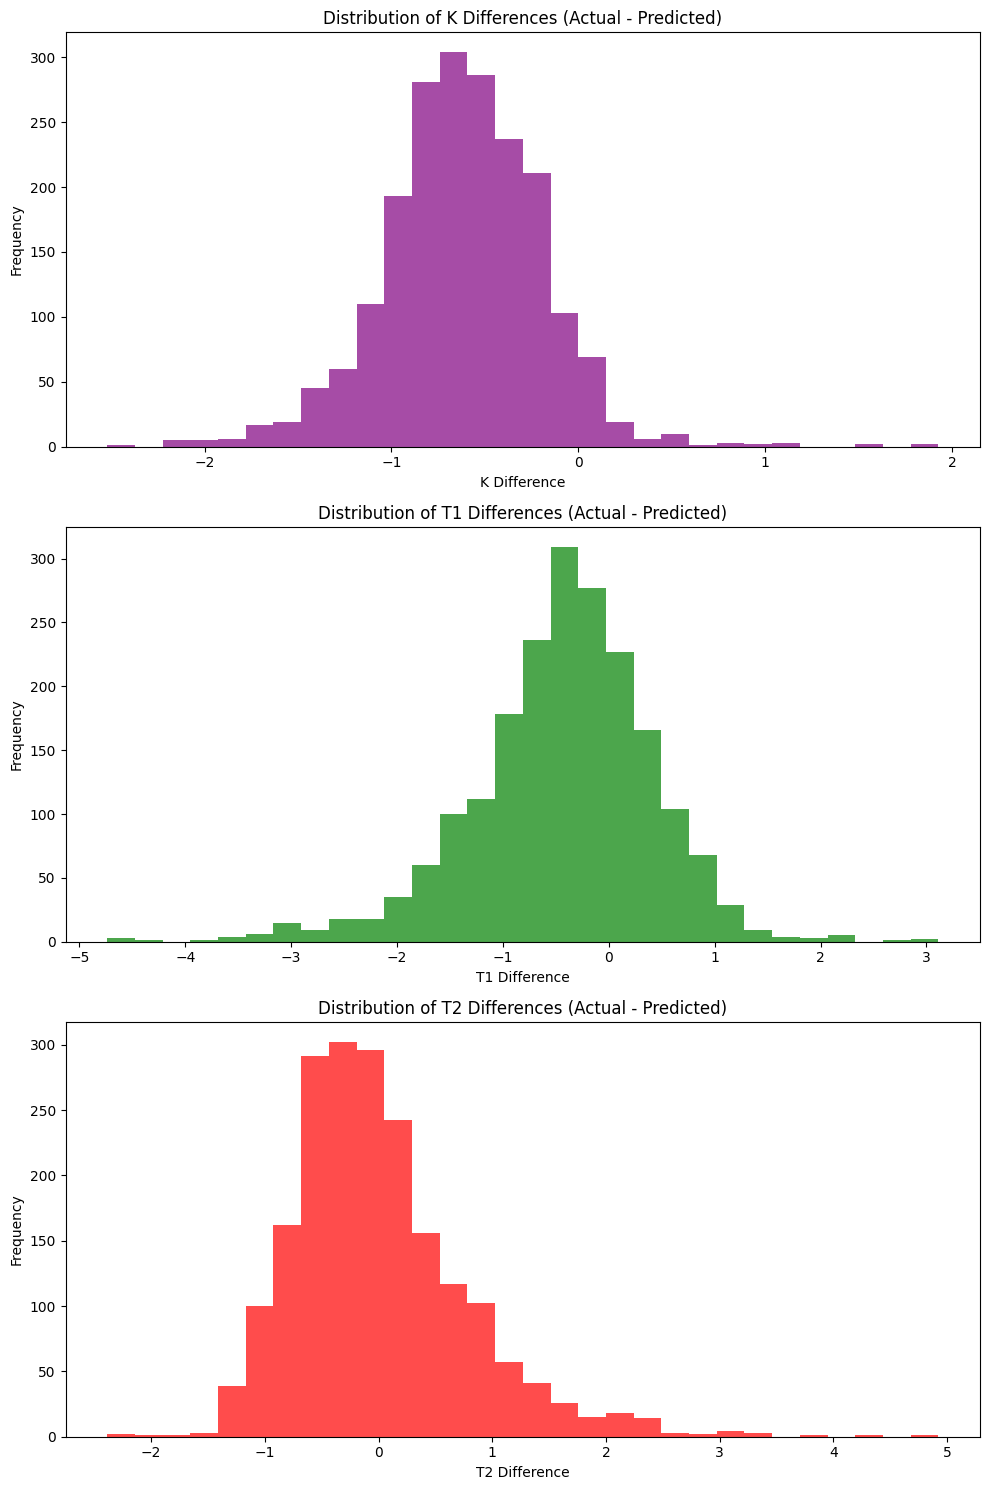

In [99]:
import matplotlib.pyplot as plt

fig_diff, axes_diff = plt.subplots(3, 1, figsize=(10, 15))

# K_DIFF distribution
axes_diff[0].hist(results_df['K_DIFF'], bins=30, color='purple', alpha=0.7)
axes_diff[0].set_title('Distribution of K Differences (Actual - Predicted)')
axes_diff[0].set_xlabel('K Difference')
axes_diff[0].set_ylabel('Frequency')

# T1_DIFF distribution
axes_diff[1].hist(results_df['T1_DIFF'], bins=30, color='green', alpha=0.7)
axes_diff[1].set_title('Distribution of T1 Differences (Actual - Predicted)')
axes_diff[1].set_xlabel('T1 Difference')
axes_diff[1].set_ylabel('Frequency')

# T2_DIFF distribution
axes_diff[2].hist(results_df['T2_DIFF'], bins=30, color='red', alpha=0.7)
axes_diff[2].set_title('Distribution of T2 Differences (Actual - Predicted)')
axes_diff[2].set_xlabel('T2 Difference')
axes_diff[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Task
Optimize the current Convolutional Neural Network (CNN) model for predicting K, T1, and T2 parameters by first establishing a baseline performance on the test set, then iteratively adjusting the learning rate of the Adam optimizer, experimenting with a more complex model architecture (adding more layers/neurons), and introducing Dropout layers for regularization. After retraining the optimized model, evaluate its performance on the test set, compare the loss and MAE metrics against the baseline, regenerate actual vs. predicted values, and visualize error distributions. Finally, summarize all optimization attempts, present the comparative results, and suggest future improvements.

## Re-evaluate current model performance

### Subtask:
Run the current model on the test set to establish a clear baseline for comparison after optimization attempts. This ensures we know the starting point before making changes.


**Reasoning**:
The user explicitly asked to evaluate the current model on the test set and store the loss and MAE as baseline metrics. This step directly addresses that requirement.



In [84]:
baseline_loss, baseline_mae = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Baseline Test Loss: {baseline_loss:.4f}")
print(f"Baseline Test MAE: {baseline_mae:.4f}")

Baseline Test Loss: 0.0500
Baseline Test MAE: 0.1464


## Adjust learning rate

### Subtask:
Modify the learning rate of the Adam optimizer. A lower learning rate can sometimes lead to better convergence, while a higher one can speed up training but risk overshooting the optimum. We'll start by trying a slightly lower learning rate.


**Reasoning**:
The subtask requires modifying the learning rate of the Adam optimizer and recompiling the model with the new optimizer. This code block will import the Adam optimizer, instantiate it with the specified learning rate, and then recompile the existing model.



In [85]:
from tensorflow.keras.optimizers import Adam

# Create a new Adam optimizer with a lower learning rate
optimizer_lr_adjusted = Adam(learning_rate=0.0005)

# Recompile the model with the new optimizer
model.compile(optimizer=optimizer_lr_adjusted, loss='mse', metrics=['mae'])

print("Model recompiled with Adam optimizer and learning rate 0.0005")

Model recompiled with Adam optimizer and learning rate 0.0005


**Reasoning**:
The model has been recompiled with the adjusted learning rate, so the next step is to retrain the model with these new settings. This will allow us to observe the impact of the learning rate change on the model's training process and performance.



In [86]:
history_lr_adjusted = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
print("Model training completed with adjusted learning rate.")

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0412 - mae: 0.1316 - val_loss: 0.0331 - val_mae: 0.1183
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0368 - mae: 0.1230 - val_loss: 0.0337 - val_mae: 0.1202
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0365 - mae: 0.1226 - val_loss: 0.0336 - val_mae: 0.1203
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0361 - mae: 0.1218 - val_loss: 0.0324 - val_mae: 0.1168
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0357 - mae: 0.1210 - val_loss: 0.0325 - val_mae: 0.1169
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0354 - mae: 0.1204 - val_loss: 0.0320 - val_mae: 0.1155
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0351 - mae: 0.1198 - val_loss: 0.0316 - val_mae: 0.1143
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0349 - mae: 0.1194 - val_loss: 0.0315 - val_mae: 0.1149
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - lo

**Reasoning**:
After retraining the model with an adjusted learning rate, it's crucial to evaluate its performance on the test set to compare it against the baseline and observe the impact of the change. This aligns with the overall task instructions.



In [87]:
loss_lr_adjusted, mae_lr_adjusted = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Adjusted LR Model Test Loss: {loss_lr_adjusted:.4f}")
print(f"Adjusted LR Model Test MAE: {mae_lr_adjusted:.4f}")

Adjusted LR Model Test Loss: 0.0273
Adjusted LR Model Test MAE: 0.1054


## Experiment with more complex model

### Subtask:
Increase the model's capacity by adding more layers or neurons to the existing Dense layers. This might allow the model to learn more intricate patterns in the data.


**Reasoning**:
The subtask requires defining a new Keras Sequential model with a more complex architecture, specifically adding more layers or neurons. This code block will create a new model instance, add an additional convolutional and pooling layer, increase the neurons in the dense layer, compile it with the specified learning rate, and then print its summary.



In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Define the new, more complex model architecture
complex_model = Sequential()

# First Conv1D and MaxPooling1D block
complex_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(600, 2)))
complex_model.add(MaxPooling1D(pool_size=2))

# Second Conv1D and MaxPooling1D block (added complexity)
complex_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
complex_model.add(MaxPooling1D(pool_size=2))

# Flatten layer
complex_model.add(Flatten())

# Dense layers with increased neurons
complex_model.add(Dense(128, activation='relu')) # Increased from 64
complex_model.add(Dense(3, activation='linear'))

# Compile the new model with the adjusted learning rate
optimizer_complex_model = Adam(learning_rate=0.0005)
complex_model.compile(optimizer=optimizer_complex_model, loss='mse', metrics=['mae'])

print("New complex model defined and compiled.")
complex_model.summary()


New complex model defined and compiled.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 598, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 299, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 297, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 148, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4736)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │       606,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,347 (2.34 MB)

 Trainable params: 613,347 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The new complex model has been defined and compiled, so the next logical step is to train this model on the scaled training data to assess its performance.



In [89]:
history_complex_model = complex_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
print("Complex model training completed.")

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.3880 - mae: 0.4387 - val_loss: 0.1723 - val_mae: 0.2807
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1861 - mae: 0.2977 - val_loss: 0.1582 - val_mae: 0.2734
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1661 - mae: 0.2845 - val_loss: 0.1454 - val_mae: 0.2701
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1537 - mae: 0.2757 - val_loss: 0.1308 - val_mae: 0.2567
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1402 - mae: 0.2630 - val_loss: 0.1230 - val_mae: 0.2532
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1273 - mae: 0.2485 - val_loss: 0.1070 - val_mae: 0.2263
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1040 - mae: 0.2194 - val_loss: 0.1072 - val_mae: 0.2248
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0936 - mae: 0.2084 - val_loss: 0.1016 - val_mae: 0.2294
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo

**Reasoning**:
The complex model has been trained, so the next logical step is to evaluate its performance on the test set to determine if the increased complexity resulted in improved metrics compared to the previous models. This evaluation is necessary to proceed with the task's optimization goals.



In [90]:
loss_complex_model, mae_complex_model = complex_model.evaluate(X_test_scaled, y_test_scaled, verbose=0)
print(f"Complex Model Test Loss: {loss_complex_model:.4f}")
print(f"Complex Model Test MAE: {mae_complex_model:.4f}")

Complex Model Test Loss: 0.0387
Complex Model Test MAE: 0.1209


**Reasoning**:
The next step is to introduce Dropout layers into the model architecture to combat overfitting, as requested by the subtask. This requires defining a new model, adding Dropout layers, and then compiling it.



In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the model architecture with Dropout layers
dropout_model = Sequential()

# First Conv1D and MaxPooling1D block
dropout_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(600, 2)))
dropout_model.add(MaxPooling1D(pool_size=2))

# Add a Dropout layer after the convolutional block
dropout_model.add(Dropout(0.2))

# Second Conv1D and MaxPooling1D block
dropout_model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
dropout_model.add(MaxPooling1D(pool_size=2))

# Flatten layer
dropout_model.add(Flatten())

# Dense layers with Dropout
dropout_model.add(Dense(128, activation='relu'))
# Add a Dropout layer after the first dense layer
dropout_model.add(Dropout(0.3))

dropout_model.add(Dense(3, activation='linear'))

# Compile the new model with the adjusted learning rate
optimizer_dropout_model = Adam(learning_rate=0.0005)
dropout_model.compile(optimizer=optimizer_dropout_model, loss='mse', metrics=['mae'])

print("Model with Dropout layers defined and compiled.")
dropout_model.summary()

Model with Dropout layers defined and compiled.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_13 (Conv1D)              │ (None, 598, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 299, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 299, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 297, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 148, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 4736)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       606,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 613,347 (2.34 MB)

 Trainable params: 613,347 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

**Reasoning**:
The 'dropout_model' has been defined and compiled with Dropout layers. The next logical step is to train this model on the scaled training data to observe its performance and assess the impact of the added regularization.



In [92]:
history_dropout_model = dropout_model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
print("Model with Dropout layers training completed.")

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.4614 - mae: 0.5055 - val_loss: 0.2861 - val_mae: 0.4193
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2464 - mae: 0.3682 - val_loss: 0.2431 - val_mae: 0.3952
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2183 - mae: 0.3473 - val_loss: 0.2120 - val_mae: 0.3660
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2113 - mae: 0.3440 - val_loss: 0.1997 - val_mae: 0.3549
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1978 - mae: 0.3349 - val_loss: 0.1930 - val_mae: 0.3469
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1944 - mae: 0.3313 - val_loss: 0.1890 - val_mae: 0.3396
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1894 - mae: 0.3275 - val_loss: 0.1859 - val_mae: 0.3473
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1814 - mae: 0.3209 - val_loss: 0.1753 - val_mae: 0.3246
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo